# 9. `xarray` Plotting (II): Plotting Data with More Than 2 Dimensions

## Global Map or Maps Crossing 180˚ Longitude

When plotting global maps on the Plate Carrée projection using `cartopy`, the default central meridian is 0˚ and the map extent is from -180˚ to 180˚ (see details in this [StackOverflow post](https://stackoverflow.com/questions/13856123/setting-up-a-map-which-crosses-the-dateline-in-cartopy#_=_)). Below is an example of a map with the default projection setting of the Plate Carrée projection.

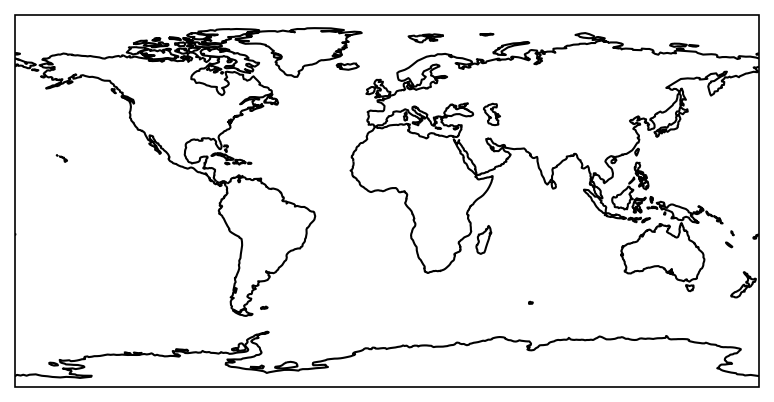

In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from cartopy import crs as ccrs   
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

mpl.rcParams['figure.dpi'] = 150

fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree()})                            
ax.set_global()  
ax.coastlines()

If we want to plot the map where the central meridian is at 180˚ longitude, we should set `central_longitude=180` for `ccrs.PlateCarree()`.


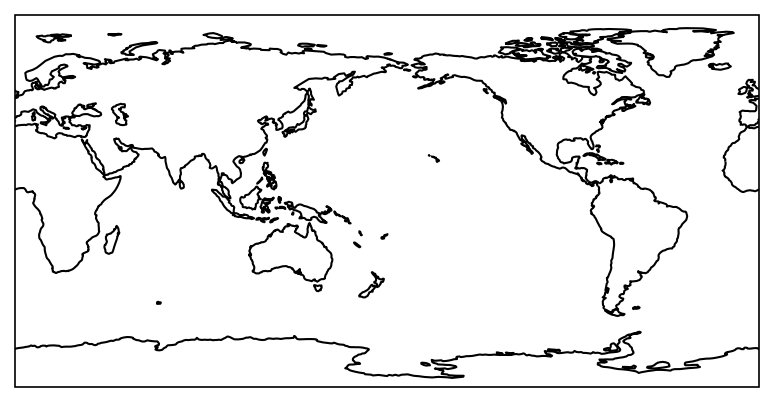

In [2]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})                            
ax.set_global()  
ax.coastlines()

To plot a filled contour map, it is important to consider the projection type of the **data** and the subplot `ax`. 

**Example 1:** Plot OLR anomaly over (20˚S-30˚N, 40˚E-150˚W).

- When creating `fig` and `ax`, specify `subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}`.
- For the plotting method, set `transform=ccrs.PlateCarree()` if the data ranges from 0˚ to 360˚. The `transform` option requires the data's projection (see [discussion](https://github.com/SciTools/cartopy/issues/645)).
- For the rest of the matplotlib settings, keep `crs=ccrs.PlateCarree()` so that matplotlib doesn't perform coordinate transformation twice.

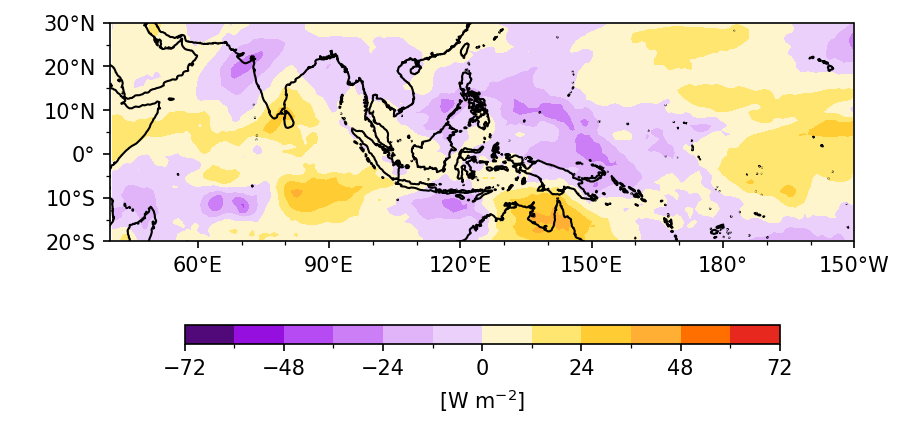

In [3]:
import xarray as xr
import numpy as np
import cmaps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def smthClmDay(clmDay, nHarm):
    from scipy.fft import rfft, irfft
    nt, ny, nx = clmDay.shape
    cf = rfft(clmDay.values, axis=0)     # xarray.DataArray.values: convert to numpy.ndarray first. 
    cf[nHarm,:,:] = 0.5*cf[nHarm,:,:]    # mini-taper.
    cf[nHarm+1:,:,:] = 0.0               # set all higher coef to 0.0
    icf = irfft(cf, n=nt, axis=0)       # reconstructed series
    clmDaySmth = clmDay.copy(data=icf, deep=False)  
    return(clmDaySmth)

lats, latn = -20, 30
lon1, lon2 =  40, 210
time1 = '2017-12-01'
time2 = '2017-12-31'

olr_ds = xr.open_dataset("data/olr.nc")
olrrt = (olr_ds.sel(time=slice(time1,time2),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr)
olrlt = (olr_ds.sel(time=slice('1998-01-01','2016-12-31'),
                    lat=slice(lats,latn),
                    lon=slice(lon1,lon2)).olr) 

olrDayClim = olrlt.groupby('time.dayofyear').mean('time')
olrDayClim_sm = smthClmDay(olrDayClim,3)
olra = olrrt.groupby('time.dayofyear') - olrDayClim_sm
olram = olra.mean(axis=0)

fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})        

plot = olram.plot.contourf("lon", "lat", ax=ax,
                           levels=[-72,-60,-48,-36,-24,-12,0,12,24,36,48,60,72],
                           cmap=cmaps.sunshine_diff_12lev,
                           add_colorbar=True,
                           transform=ccrs.PlateCarree(),  # Data's projection.
                           cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': r"[W m$^{-2}$]"})

ax.set_extent([lon1, lon2, lats, latn], crs=ccrs.PlateCarree())
ax.coastlines()
ax.set_xticks(np.arange(60,240,30),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(60,220,10),minor=True,crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_yticks(np.arange(-20,40,10),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,35,5),crs=ccrs.PlateCarree(),minor=True)
ax.set_xlabel(' ')
ax.set_ylabel(' ')

plt.show()

To sum up, the `fig`, subplot `ax`, and data each have their own projection, and these projection systems may not be the same. We set the map projection when we create the subplot `ax` initially, and we set `transform` for the data projection in the plot method. In the next example, we will illustrate this concept again by plotting the 500-hPa geopotential height on a polar map.


## Other Map Projection Types

In the previous example, we use and equirectangular projection map `ccrs.PlateCarree()`. Cartopy also provided other projection methods, see [Cartopy projection list](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html).

**Example 2:** Plot 500-hPa geopotential height on the polar map. (Use `ccrs.Orthographic`)。

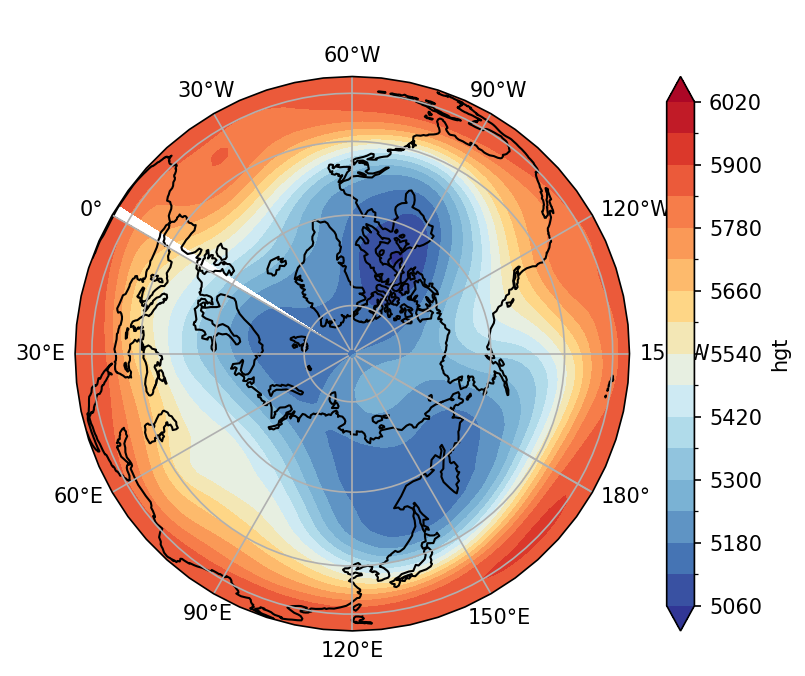

In [4]:
time1 = '2017-12-01'
time2 = '2017-12-31'

zds = xr.open_dataset('data/ncep_r2_h500.2017.nc')
z = zds.sel(time=slice(time1,time2),
            lat=slice(90,0),
            level=500).hgt
zm = z.mean(axis=0)

fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.Orthographic(central_longitude=120, central_latitude=90)})   

# Plot settings 
clev = range(5060,6080,60)
plot = zm.plot.contourf(levels=clev,ax=ax,
                        cmap=cmaps.cmp_b2r, extend='both',
                        transform=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True,
             xlocs=np.arange(-180,240,30))
ax.set_title(' ')

plt.show()

The method requires to plot the entire hemisphere latitude. If we only plot a certain latitude range, see the solution below using `ccrs.NorthPolarStereo()`. However, it is rather complicated. 

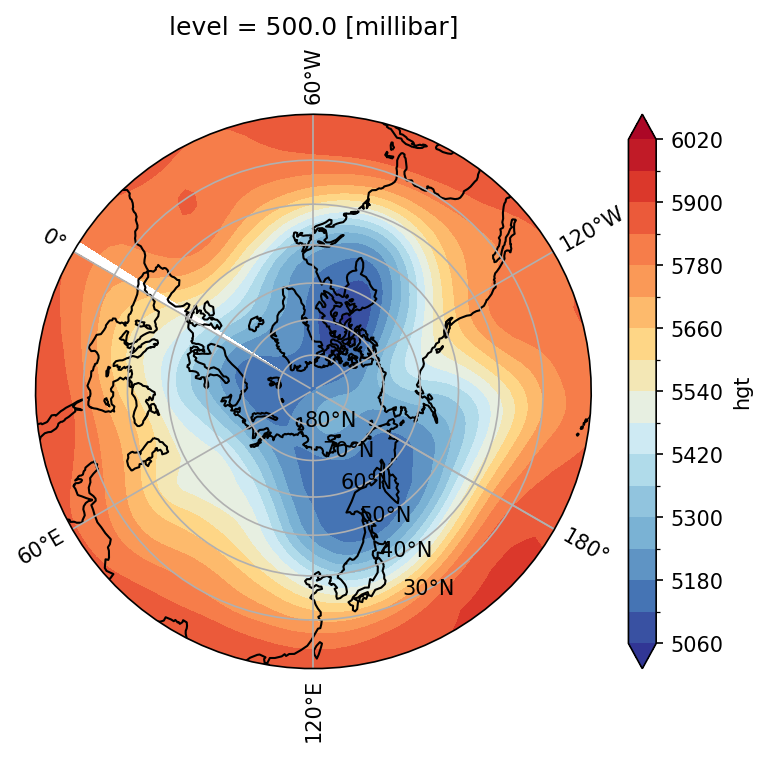

In [5]:
import matplotlib.path as mpath

z = zds.sel(time=slice(time1,time2),
            lat=slice(90,20),
            level=500).hgt
zm = z.mean(axis=0)

# Plot settings 
fig, ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.NorthPolarStereo(central_longitude=120)})
clev = range(5060,6080,60)
plot = zm.plot.contourf(levels=clev,ax=ax,
                        cmap=cmaps.cmp_b2r, extend='both',
                        transform=ccrs.PlateCarree())
ax.set_extent([0, 360, 20, 90], ccrs.PlateCarree())
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, 
                  xlocs=np.arange(-180,240,60))
gl.ylabels_right = False

plt.show()

Again, when we create the subplot `ax`, we set the map projection type (e.g., `ccrs.Orthographic` or `ccrs.NorthPolarStereo()`) using `subplot_kw`. When we plot the geopotential height `zm`, we specify the data's projection type with `transform=ccrs.PlateCarree()` because the netCDF file with latitude and longitude grids is equirectangular. This allows Python to properly transform the data coordinates onto the map projection type.

## Hovmöller Diagram

A Hovmöller Diagram is essentially a type of filled contour plot where the `y` axis represents the time dimension and the `x` axis represents the latitude dimension. To display the chronological order on the y-axis from top to bottom in the diagram, add the option `yincrease=False` to the plotting method.

**Example 3:** Plot a Hovmöller diagram of daily OLR averaged over 5˚S to 5˚N for December 2017.

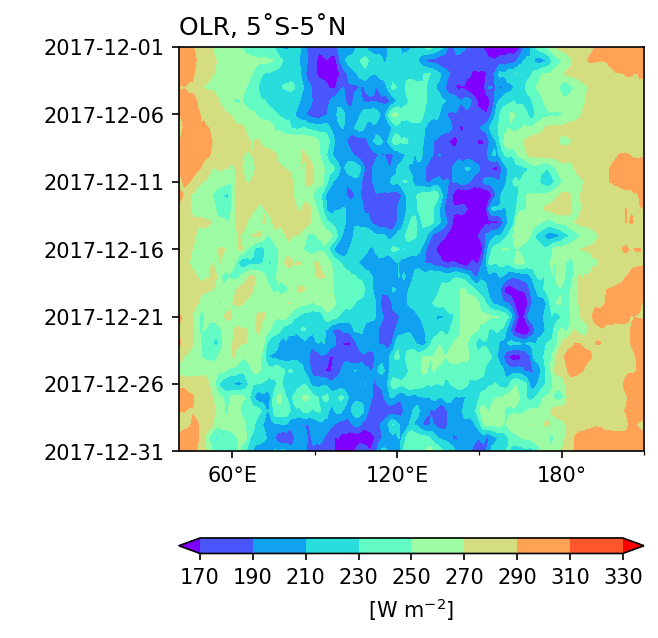

In [6]:
import pandas as pd

lats, latn = -5, 5

olrm = olrrt.sel(lat=slice(lats,latn)).mean("lat")
time = olrm.time

# Plot settings
fig, ax = plt.subplots(1,1,figsize=(4, 5)) # Don't set the projection keyword!

clevs = range(170,350,20)
hovm_plot = olrm.plot.contourf(x="lon", y="time",
                               ax=ax, 
                               levels=clevs,                    
                               cmap='rainbow',  
                               yincrease=False,                 # y axis be increasing from top to bottom
                               add_colorbar=True, 
                               extend='both',                   # color bar 兩端向外延伸
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'label': r'[W m$^{-2}$]'})
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.set_xticks(np.arange(60,240,60))
ax.set_xticks(np.arange(60,240,30),minor=True)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_yticks(time[0::5])
ax.set_title('OLR, 5˚S-5˚N',loc='left')
plt.show()

```{note}
Because we don't use `cartopy` to plot a Hovmöller diagram, we don't need to specify projection settings to cross 180˚ here.
```

## Contour Plot and Overlay 

We can plot contour using `xarray.DataArray.plot.contour()`. The settings are very similar to filled contour plot.

**Example 4:** Plot monthly mean GPCP precpitation and mean sea level pressure (MSLP) in December 2017. Plot rainfall map with color shading, and MSLP with contour lines. 

Step 1: Data preparation. 

In [7]:
lats = -20
latn =  60
lon1 =  30
lon2 = 210

pds = xr.open_dataset('data/gpcp_precip_1979-2019.pentad.nc')
pcp = pds.sel(time=slice('2017-12-01','2017-12-31'), 
              lat=slice(latn,lats),
              lon=slice(lon1,lon2)).data
slp_ds = xr.open_dataset('data/mslp.2017.nc')
mslp = slp_ds.sel(time=slice('2017-12-01','2017-12-31'), 
                  lat=slice(latn,lats),
                  lon=slice(lon1,lon2)).mslp

pcpm = pcp.mean(axis=0)
slpm = mslp.mean(axis=0)
slpm = slpm/100.  # Convert to hPa

Step 2: Plotting. To plot two fields on the same figure, you need to ensure that they share a common subplot `ax`. This can be achieved by specifying the same `ax` object in both plot methods, allowing the fields to be overlaid on top of each other.

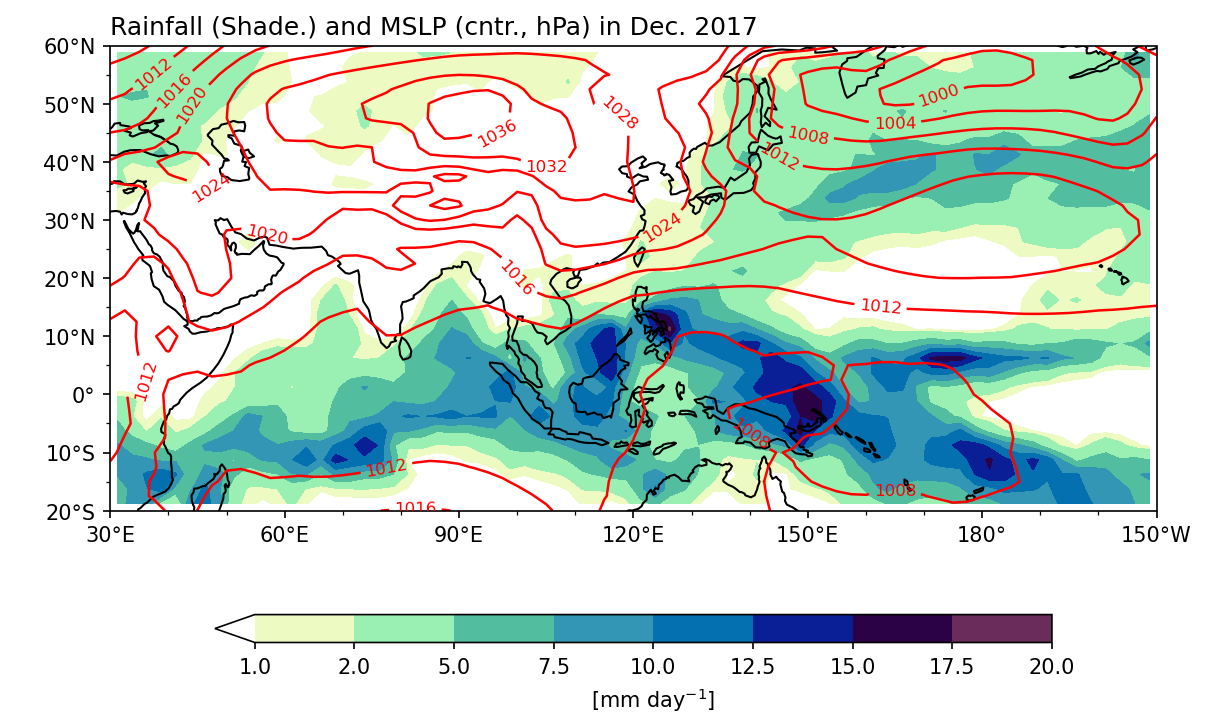

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))                        

clev = [1,2,5,7.5,10,12.5,15,17.5,20]
cf = pcpm.plot.contourf("lon", "lat", ax=ax,
                           levels=clev,
                           cmap=cmaps.precip_11lev,
                           add_colorbar=True,
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': r"[mm day$^{-1}$]"})
cl = slpm.plot.contour("lon", "lat", ax=ax,  # Same `ax` as `cf`!
                         levels=range(980,1048,4),
                         linewidths=1.2,
                         colors='red',
                         transform=ccrs.PlateCarree())

ax.clabel(cl, inline=True, fontsize=8)    # Set contour line labels. 

ax.set_extent([lon1, lon2, lats, latn], crs=ccrs.PlateCarree())
ax.coastlines()
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(30,240,30),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(30,220,10),crs=ccrs.PlateCarree(),minor=True)
ax.set_yticks(np.arange(-20,70,10),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,65,5),crs=ccrs.PlateCarree(),minor=True)
ax.set_xlabel(' ')
ax.set_ylabel(' ')

ax.set_title('Rainfall (Shade.) and MSLP (cntr., hPa) in Dec. 2017',loc='left')

plt.show()

## Plotting Wind Field and Overlay

Wind field is multivariate data (U, V). We need to **merge** the two DataArrays to a `xarray.Dataset` to pass over `xarray.Dataset.plot.quiver()` method. To merge DataArrays into a Dataset, we have to use `xarray.merge()`.

**Example 5:** Plot monthly mean OLR and 850-hPa wind field in December 2017. Plot OLR map with color shading, and wind field with vectors.  

In [9]:
lats = -45
latn =  45
lon1 =  30
lon2 = 210

uds = xr.open_dataset('data/ncep_r2_uv850/u850.2017.nc')
vds = xr.open_dataset('data/ncep_r2_uv850/v850.2017.nc')
u = uds.sel(time=slice(time1,time2),
            lat=slice(latn,lats),
            lon=slice(lon1,lon2),
            level=850).uwnd
v = vds.sel(time=slice(time1,time2),
            lat=slice(latn,lats),
            lon=slice(lon1,lon2),
            level=850).vwnd
um = u.mean(axis=0)
vm = v.mean(axis=0)

wnd = xr.merge([um,vm])   # Merge two DataArrays into a Dataset.
wnd 

<xarray.Dataset> Size: 22kB
Dimensions:  (lon: 73, lat: 37)
Coordinates:
  * lon      (lon) float32 292B 30.0 32.5 35.0 37.5 ... 202.5 205.0 207.5 210.0
  * lat      (lat) float32 148B 45.0 42.5 40.0 37.5 ... -37.5 -40.0 -42.5 -45.0
    level    float32 4B 850.0
Data variables:
    uwnd     (lat, lon) float32 11kB 9.181 9.696 9.499 ... 4.067 4.576 5.064
    vwnd     (lat, lon) float32 11kB 2.825 4.076 4.622 ... 2.835 2.263 1.643

We first plot the wind field. 

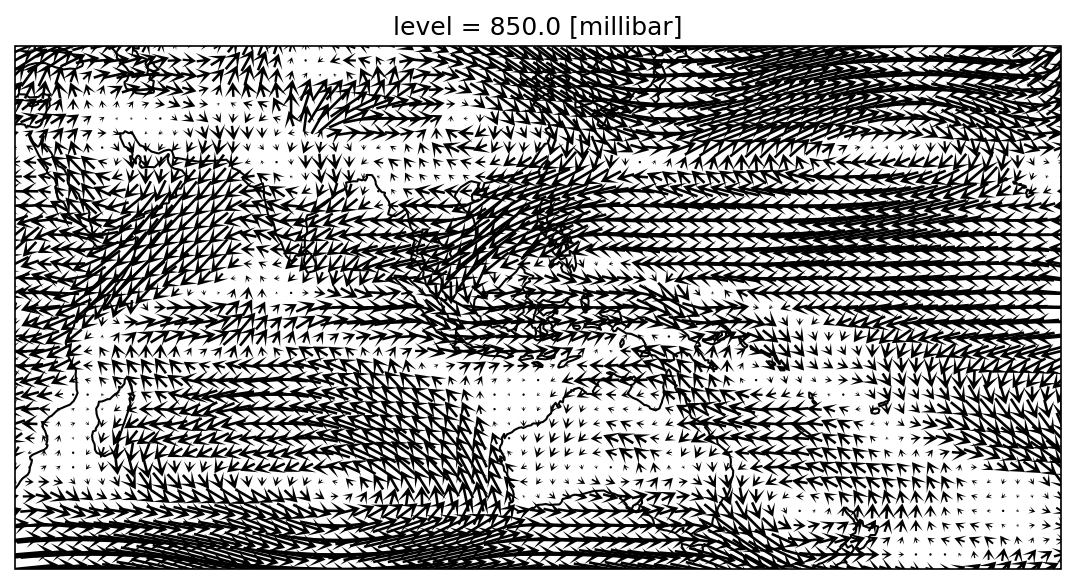

In [10]:
fig, ax = plt.subplots(1,1,figsize=(9,6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))   
wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd', 
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()
plt.show()

The arrows in the above chart are too dense and bunched together. How can we adjust this? We can plot vectors every 2 grids (or 5˚), or coarsen the wind field resolution. 

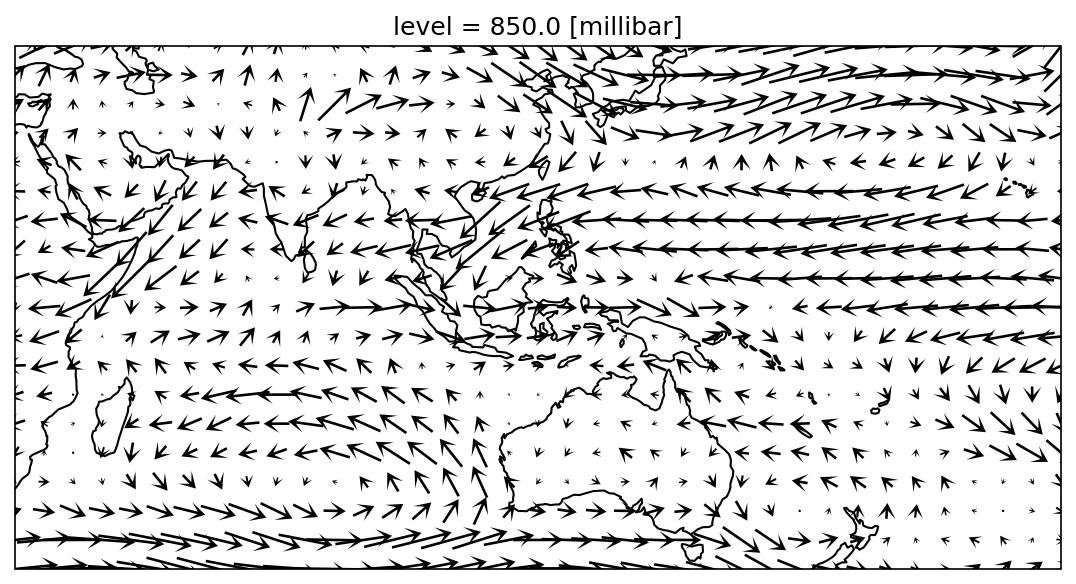

In [11]:
fig, ax = plt.subplots(1,1,figsize=(9,6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))  

wnd = xr.merge([um[::2,::2],vm[::2,::2]])
wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd',
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )
ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

plt.show()

Overlay wind field on the OLR map: 

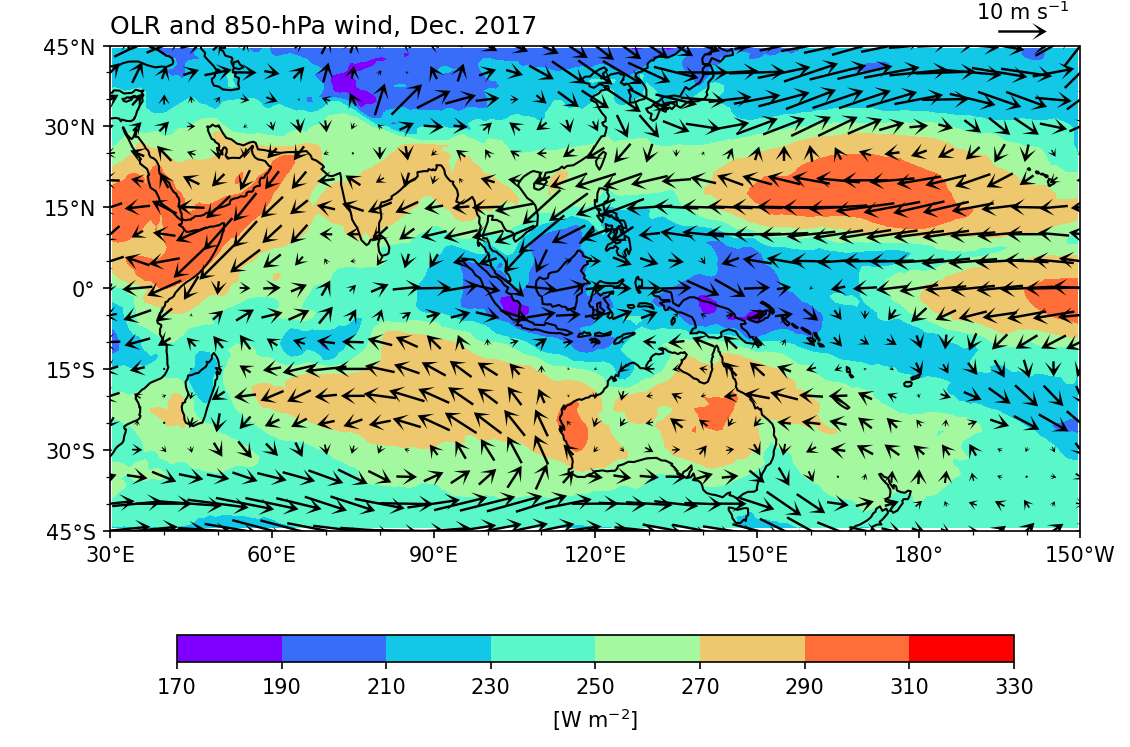

In [12]:
olr = olr_ds.sel(time=slice(time1,time2),
                 lat=slice(lats,latn),
                 lon=slice(lon1,lon2)).olr
olrm = olr.mean(axis=0)

fig, ax = plt.subplots(1,1,figsize=(9,6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))  


olr_plot = olrm.plot.contourf("lon", "lat", ax=ax,
                               levels=range(170,350,20),
                               cmap='rainbow', add_colorbar=True,
                               transform=ccrs.PlateCarree(),
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': r"[W m$^{-2}$]"})

wind_plt = wnd.plot.quiver(ax=ax,
                           transform=ccrs.PlateCarree(),
                            x='lon', y='lat',
                            u='uwnd', v='vwnd',
                            add_guide=False, 
                            width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                            scale=200, colors="black",
                            )
# 加上風標
qk = 10
qv_key = ax.quiverkey(wind_plt,0.94,1.03,10,r'10 m s$^{-1}$',labelpos='N', labelsep =0.05, color='black')

ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(30,240,30),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(30,220,10),crs=ccrs.PlateCarree(),minor=True)
ax.set_yticks(np.arange(-45,60,15),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,50,5),crs=ccrs.PlateCarree(),minor=True)
ax.set_xlabel(' ')
ax.set_ylabel(' ')

ax.set_title(' ')
ax.set_title('OLR and 850-hPa wind, Dec. 2017', loc='left')

plt.show()


- Notice that `ax=ax` is used for both `olrm.plot.contourf()` and `wnd.plot.quiver()`. This ensures that both plots share a common subplot, allowing the wind field to be overlaid on the OLR.
- The `scale` option in `.plot.quiver()` sets the number of data units per arrow length unit, effectively controlling the size of the vectors. Generally, a larger number results in smaller vectors.
- **Reference vector:** Use `ax.quiverkey()`:

> `quiverkey(Q: Quiver, X: float, Y: float, U: float, label: str, **kw: Any) -> QuiverKey`

Specify `Q` as the name of the quiver plot (e.g., `wind_plt`), `X` and `Y` for the location of the reference vector, and `U` for the reference length (in m s $^{-1}$).
- Add `add_guide=False` in the `wnd.plot.quiver()` method to suppress the default reference vector.


## Streamplot

The usage is essentially the same as for the wind field plot. Simply replace `plot.quiver()` with `plot.streamplot()`.

**Example 6:** The same as **Example 5**, but to plot the wind field as streamline. 

<Figure size 1350x900 with 0 Axes>

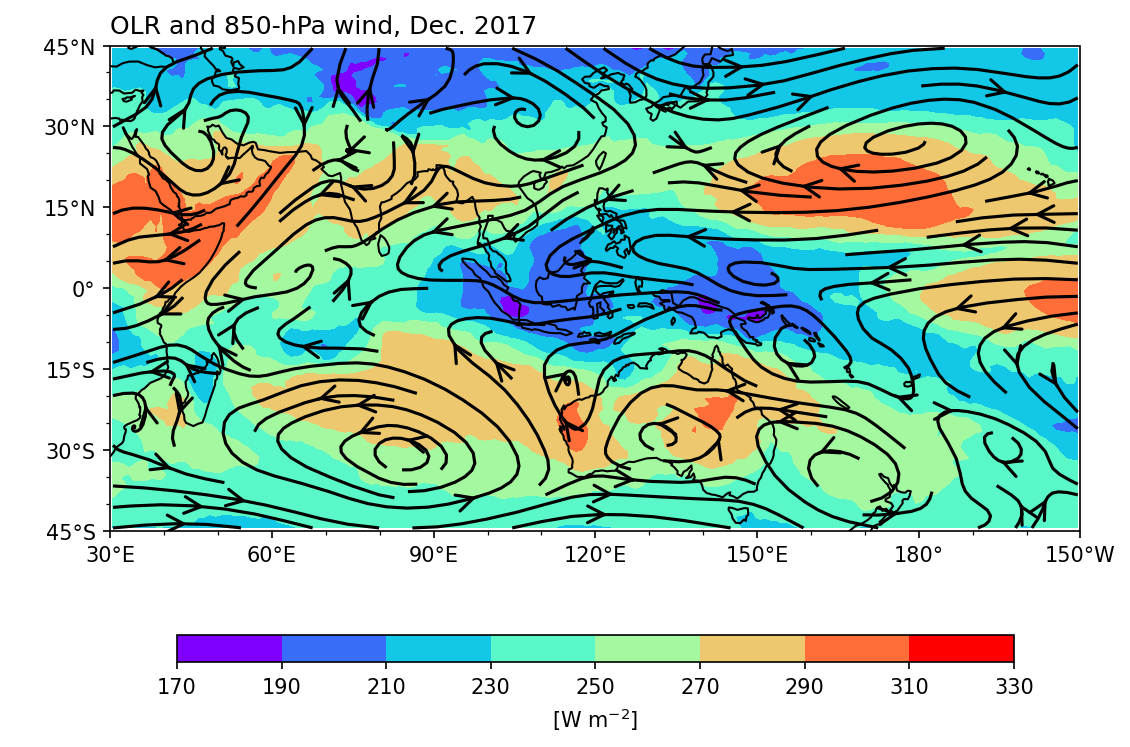

In [13]:
wnd = xr.merge([um,vm]) 

plt.figure(figsize=[9,6])                            
fig, ax = plt.subplots(1,1,figsize=(9,6), 
                       subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))  


olr_plot = olrm.plot.contourf("lon", "lat", ax=ax,
                               levels=range(170,350,20),
                               cmap='rainbow', add_colorbar=True,
                               transform=ccrs.PlateCarree(),
                               cbar_kwargs={'orientation': 'horizontal', 'aspect': 30, 'shrink': 0.8, 'label': r"[W m$^{-2}$]"})

wind_plt = wnd.plot.streamplot(ax=ax,
                              transform=ccrs.PlateCarree(),
                               x='lon', y='lat',
                               u='uwnd', v='vwnd',
                               arrowsize=2,arrowstyle='->',
                               color="black",
                               )

ax.set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
ax.coastlines()

ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(30,240,30),crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(30,220,10),crs=ccrs.PlateCarree(),minor=True)
ax.set_yticks(np.arange(-45,60,15),crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-45,50,5),crs=ccrs.PlateCarree(),minor=True)
ax.set_xlabel(' ')
ax.set_ylabel(' ')

ax.set_title(' ')
ax.set_title('OLR and 850-hPa wind, Dec. 2017', loc='left')

plt.show()


```{caution}
In the API reference of [`matplotlib.pyplot.streamplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.streamplot.html),

> x, y - 1D/2D arrays: Evenly spaced strictly increasing arrays to make a grid. 

Therefore, order the data from west to east and from south to north for `streamplot`. If the latitude coordinate is ordered from north to south, reorder the coordinate by adding `da = da[:,::-1,:]` (assuming the 1st axis is the latitude axis). This step is only required for `streamplot`!
```

## Panel Plots

**Example 7:** Plot pentad mean OLR and 850-hPa wind maps in December 2017. (There are 6 pentads in a month, so we will have 6 subplots.)

Step 1: Prepare data and calculate the pentad mean. 

In [14]:
olr_pm = olr.coarsen(time=5,boundary='trim',coord_func='min').mean()
upm = u.coarsen(time=5,boundary='trim',coord_func='min').mean()
vpm = v.coarsen(time=5,boundary='trim',coord_func='min').mean()
wnd = xr.merge([upm[:,::3,::3],vpm[:,::3,::3]])

Step 2: Plotting.

We create a `fig` with 6 subplots `axes`, arranged in 3 rows and 2 columns. Flatten `axes` into a list of `ax` objects so that we can control them individually.

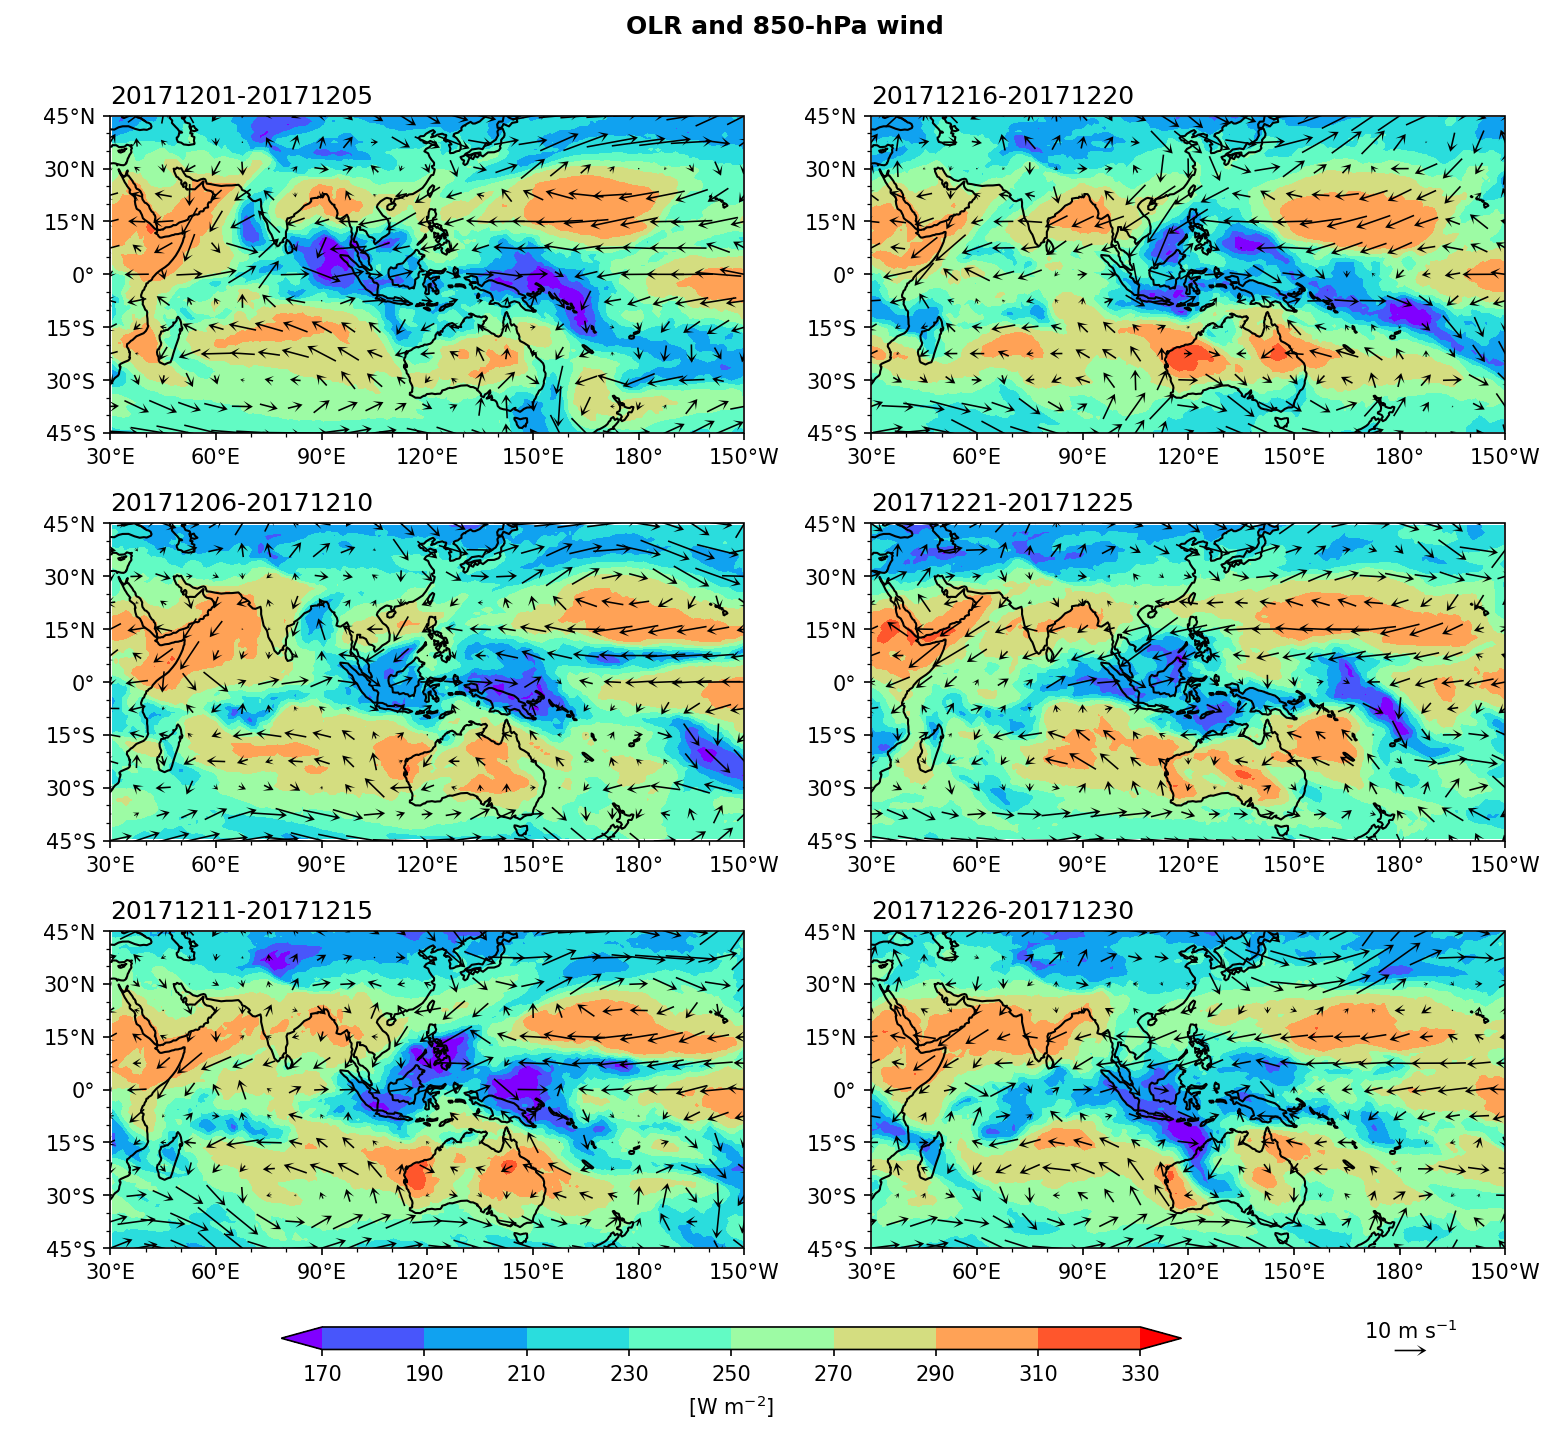

In [15]:
fig, axes = plt.subplots(3,2,figsize=(12,10),
                        subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
ax = axes.flatten()

clev = range(170,350,20)

porder = [0,2,4,1,3,5]  # To determine the plot order at each pentad. 

for i in range(0,6):
    cf = olr_pm[i,:,:].plot.contourf('lon','lat',
                                     ax=ax[porder[i]],
                                     levels=clev,
                                     cmap='rainbow', add_colorbar=False,
                                     extend='both',
                                     transform=ccrs.PlateCarree())
    qv = wnd.isel(time=i).plot.quiver(ax=ax[porder[i]],
                                      transform=ccrs.PlateCarree(),
                                      x='lon', y='lat',
                                      u='uwnd', v='vwnd',
                                      add_guide=False,
                                      width=0.0025 ,headaxislength=3,headlength=6,headwidth=7,
                                      scale=200, colors="black"
                                      )
    ax[porder[i]].coastlines()
    ax[porder[i]].set_extent([lon1,lon2,lats,latn], crs=ccrs.PlateCarree())
    ax[porder[i]].xaxis.set_major_formatter(lon_formatter)
    ax[porder[i]].yaxis.set_major_formatter(lat_formatter)
    ax[porder[i]].set_xticks(np.arange(30,240,30),crs=ccrs.PlateCarree())
    ax[porder[i]].set_xticks(np.arange(30,220,10),crs=ccrs.PlateCarree(),minor=True)
    ax[porder[i]].set_yticks(np.arange(-45,60,15),crs=ccrs.PlateCarree())
    ax[porder[i]].set_yticks(np.arange(-45,50,5),crs=ccrs.PlateCarree(),minor=True)
    ax[porder[i]].set_xlabel(' ')
    ax[porder[i]].set_ylabel(' ')
    ax[porder[i]].set_title(' ')
    ax[porder[i]].set_title(time[i*5].dt.strftime('%Y%m%d').values + '-' + time[i*5+4].dt.strftime('%Y%m%d').values, loc='left')
    
    i = i + 1

# Add reference wind vector
qk = 10
qv_key = ax[5].quiverkey(qv,0.85,-0.32,10,r'10 m s$^{-1}$',labelpos='N', labelsep =0.05, color='black')

# The title of this figure
fig.suptitle('OLR and 850-hPa wind', size='large',weight='demibold', y=0.94)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.22, 0.05, 0.5, 0.015])
# Draw the colorbar on cbar_ax.
cbar = fig.colorbar(cf, cax=cbar_ax,orientation='horizontal',ticks=clevs,label=r'[W m$^{-2}$]')

# Adjust the spacing of subplots.
fig.subplots_adjust(wspace=0.2, hspace=0.2)

plt.show()